# Load Library and Data

In [1]:
import gc
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from scipy.stats import rankdata

warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [3]:
# Dimension of Train and Test Data
train_df.shape, test_df.shape

((262144, 258), (131073, 257))

In [4]:
train_df.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [5]:
test_df.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
0,1c13f2701648e0b0d46d8a2a5a131a53,-5.490030,0.593976,1.532732,-0.361234,-0.155282,-1.340582,1.626819,4.280084,-0.340155,-0.653070,2.817394,1.211543,-0.819354,-0.019935,0.634466,-1.604789,0.756771,0.451960,0.309252,-4.628353,-0.270163,-0.183827,0.099529,0.719685,-1.077965,-1.704726,0.263344,1.183083,-1.967262,-0.364729,-1.553005,0.667643,-1.647120,-0.118086,1.095897,-3.725086,0.571565,5.407131,1.599479,...,-0.007170,-0.723353,-0.317083,3.892687,0.732599,-0.829353,-1.281645,5.256029,0.484761,0.315440,-1.256456,-0.065537,0.243787,-0.085292,0.293226,-0.727176,-0.026991,-0.452266,1.733475,-0.511201,-0.913642,-2.237558,-1.607618,-0.497308,0.004124,-1.854472,1.499102,-0.701304,-0.573827,0.121455,0.386831,0.817764,-1.215121,0.238812,-0.507346,1.360599,-1.743894,1.412043,-0.562730,-0.237948
1,ba88c155ba898fc8b5099893036ef205,0.571698,0.495494,1.133975,-0.315875,-2.142458,-0.478650,-1.458941,0.977352,0.159189,0.425304,1.366214,-1.097810,-0.128929,-0.563375,-0.389307,-0.167991,0.314843,0.530220,-0.512497,0.526404,1.612939,-0.800211,0.692056,2.541566,0.290910,-0.726153,1.307040,0.964062,0.235339,3.553998,-0.769491,-1.706831,0.227793,-1.027914,1.359388,-1.296281,0.216550,0.166792,-1.361746,...,8.867017,0.145251,-2.429107,-1.994984,0.692641,-0.922336,-0.442788,-0.357402,0.606270,-0.144259,-0.019312,0.132073,-1.038829,-0.361597,-0.019181,0.656320,-0.029080,-0.263428,-1.674349,0.237658,-0.539413,3.683862,0.341788,0.321800,1.919056,-0.680074,-0.851474,-0.802017,1.984299,0.606214,-1.120400,-0.953432,0.266619,-2.088512,0.252637,-1.034676,-0.804765,0.639112,1.172667,-1.666513
2,7cbab5cea99169139e7e6d8ff74ebb77,0.478202,-1.429985,0.41

In [6]:
print(train_df.info())
print('\n')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Columns: 258 entries, id to target
dtypes: float64(255), int64(2), object(1)
memory usage: 516.0+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131073 entries, 0 to 131072
Columns: 257 entries, id to gamy-white-monster-expert
dtypes: float64(255), int64(1), object(1)
memory usage: 257.0+ MB
None


Train Data
- id
- target (0 or 1: binary)
- 256 features

Test Data
- id
- 256 features

# Missing Data?

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
#     if np.tranpose(tt).loc['Total'].sum()==0:
#         print("No missing value in the entire data")
    return(np.transpose(tt))

In [8]:
# Checking for missing data for train data
missing_data(train_df)
print(missing_data(train_df).loc['Total'].sum())

0


In [9]:
# Checking for missing data for test data
missing_data(test_df)
print(missing_data(test_df).loc['Total'].sum())

0


No missing values in both train and test data!

# Summary Statistics of data

In [10]:
train_df.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
count,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,...,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000,262144.000000
mean,0.005924,0.000936,-0.012530,-0.005688,0.001607,0.007878,-0.003500,-0.005927,0.002664,0.020485,-0.001629,0.008115,-0.001445,0.006434,0.013150,-0.016462,0.014498,0.000990,-0.004702,-0.010490,0.006592,-0.007705,0.010857,-0.011858,-0.005172,-0.012855,-0.003606,0.001209,0.007980,-0.005911,-0.000397,-0.000490,-0.013010,-0.000040,0.003882,-0.008507,-0.009352,0.007037,0.004091,-0.011576,...,-0.002381,-0.010963,0.005069,0.001779,0.011217,-0.000718,-0.008141,0.003521,0.011593,-0.011187,0.001626,0.000656,0

In [11]:
test_df.describe()

,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,flaky-goldenrod-bat-noise,...,dorky-purple-kiwi-hint,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert
count,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,...,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000,131073.000000
mean,0.000717,-0.001042,-0.014509,-0.007666,0.003343,0.001975,-0.003154,-0.003252,-0.000867,0.021517,0.008928,-0.001051,-0.006368,-0.002891,0.010515,-0.023823,0.000880,0.003780,-0.009165,-0.000505,0.011933,-0.003440,0.005804,0.003148,-0.016712,-0.009732,-0.002171,0.001297,0.009926,-0.003764,-0.003134,-0.010153,-0.014269,-0.000145,0.003224,-0.012756,-0.003288,0.000392,0.006548,-0.012575,...,0.006470,-0.010495,-0.008946,0.008752,0.002811,0.020735,-0.002210,-0.009315,0.007151,0.007063,-0

# Distribution of Target

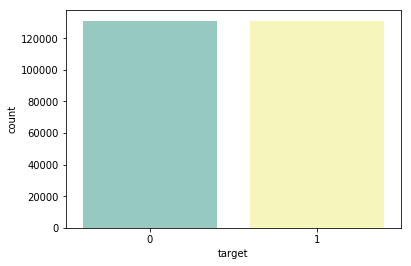

In [12]:
sns.countplot(train_df['target'], palette='Set3')

In [13]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 50.02250671386719% target values with 1


Target is very well balanced (surprisingly)!!!

# Density Plots of Features

In [14]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(8,8,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

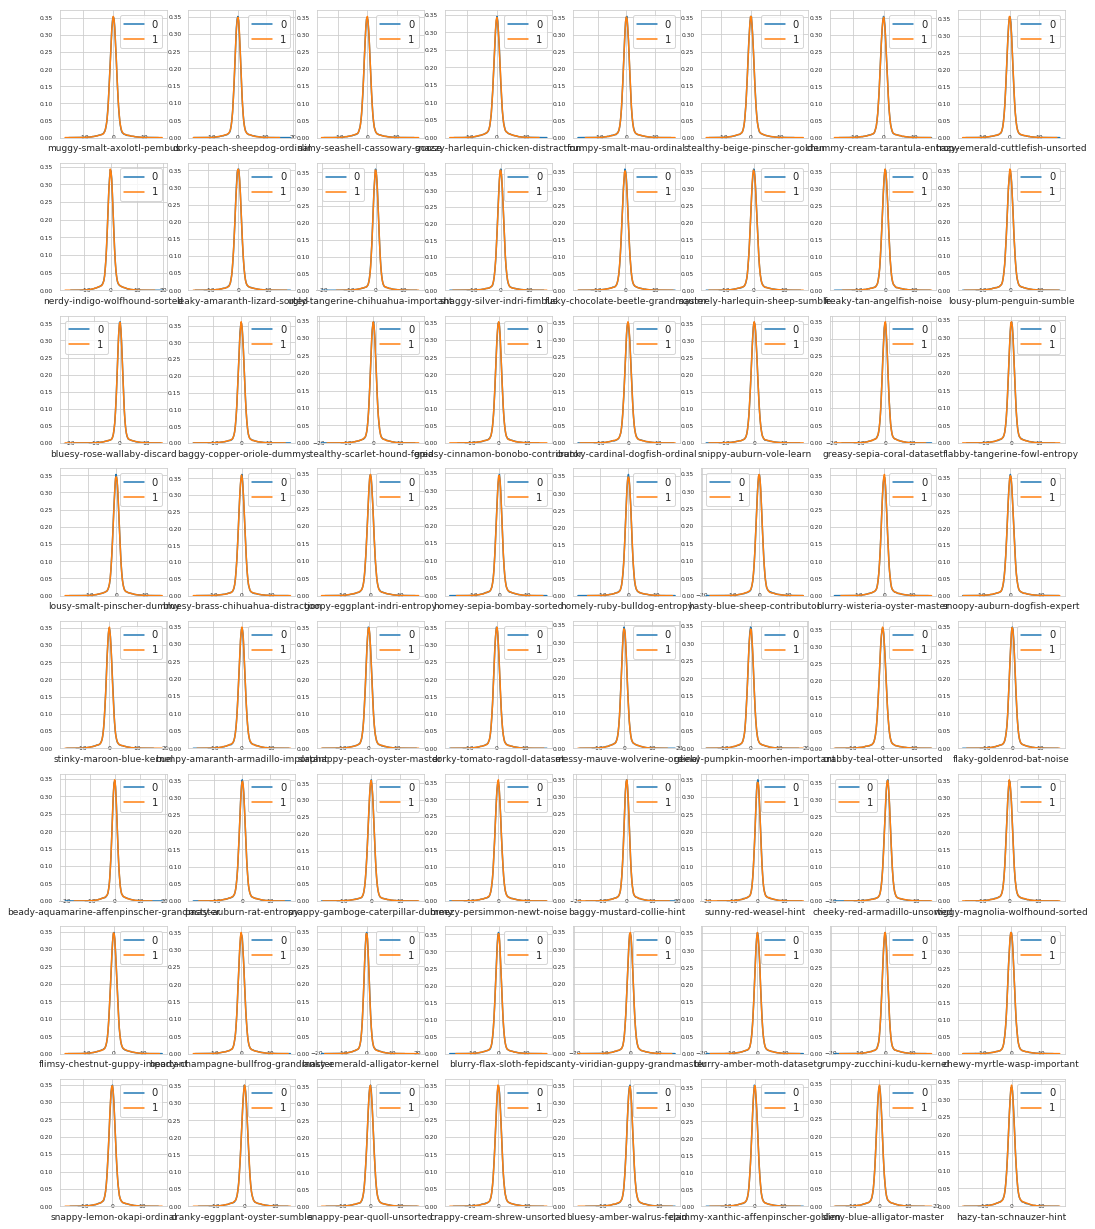

<Figure size 432x288 with 0 Axes>

In [15]:
# The first 64 features
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[1:65]
plot_feature_distribution(t0, t1, '0', '1', features)
plt.tight_layout()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


<Figure size 432x288 with 0 Axes>

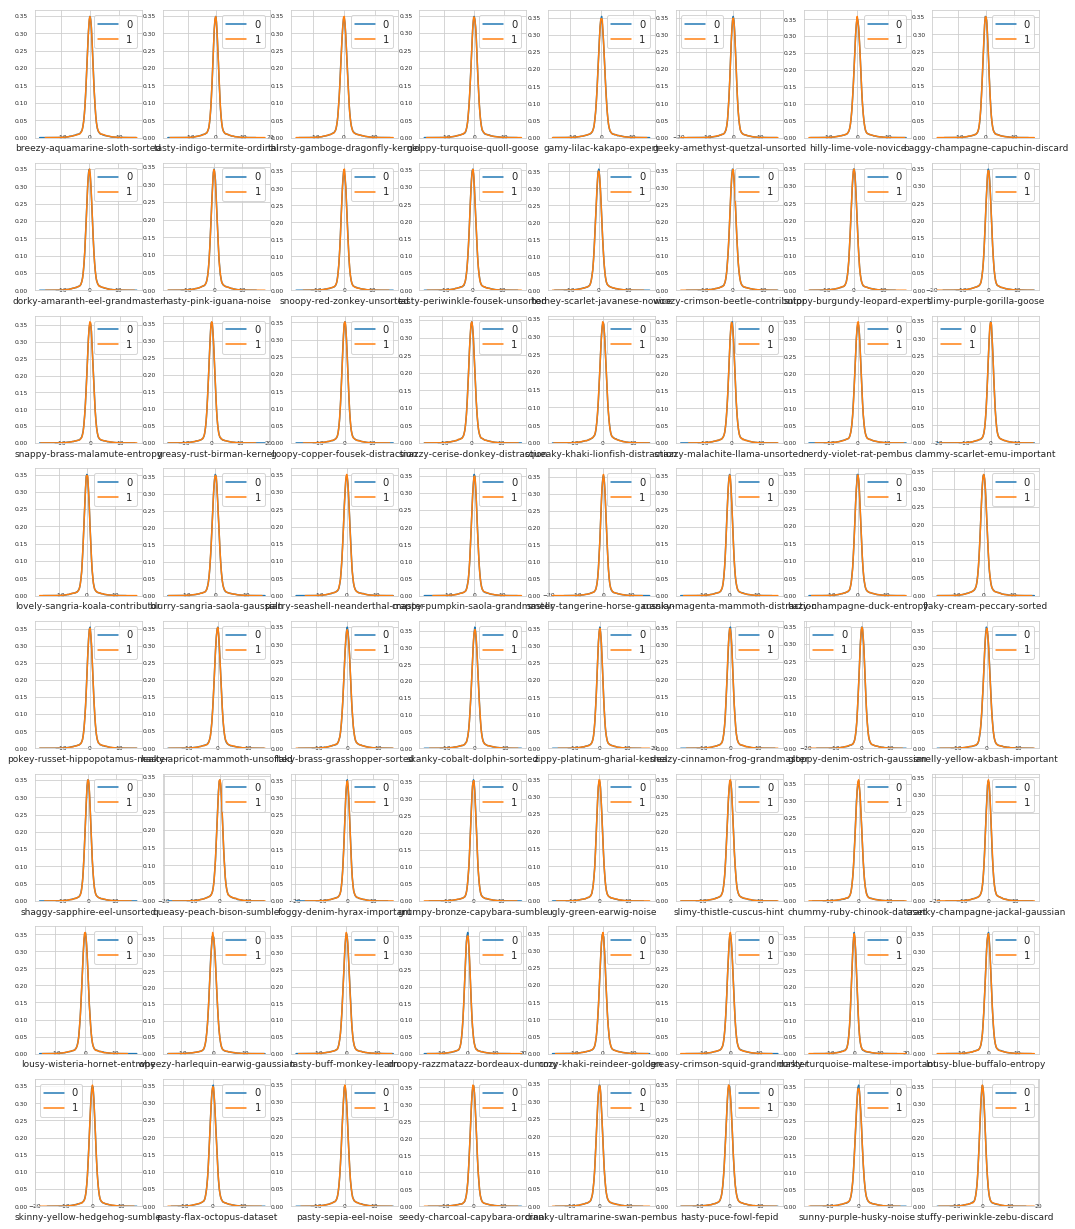

In [16]:
# Another 64 features
%time
features = train_df.columns.values[65:129]
plot_feature_distribution(t0, t1, '0', '1', features)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.7 µs


<Figure size 432x288 with 0 Axes>

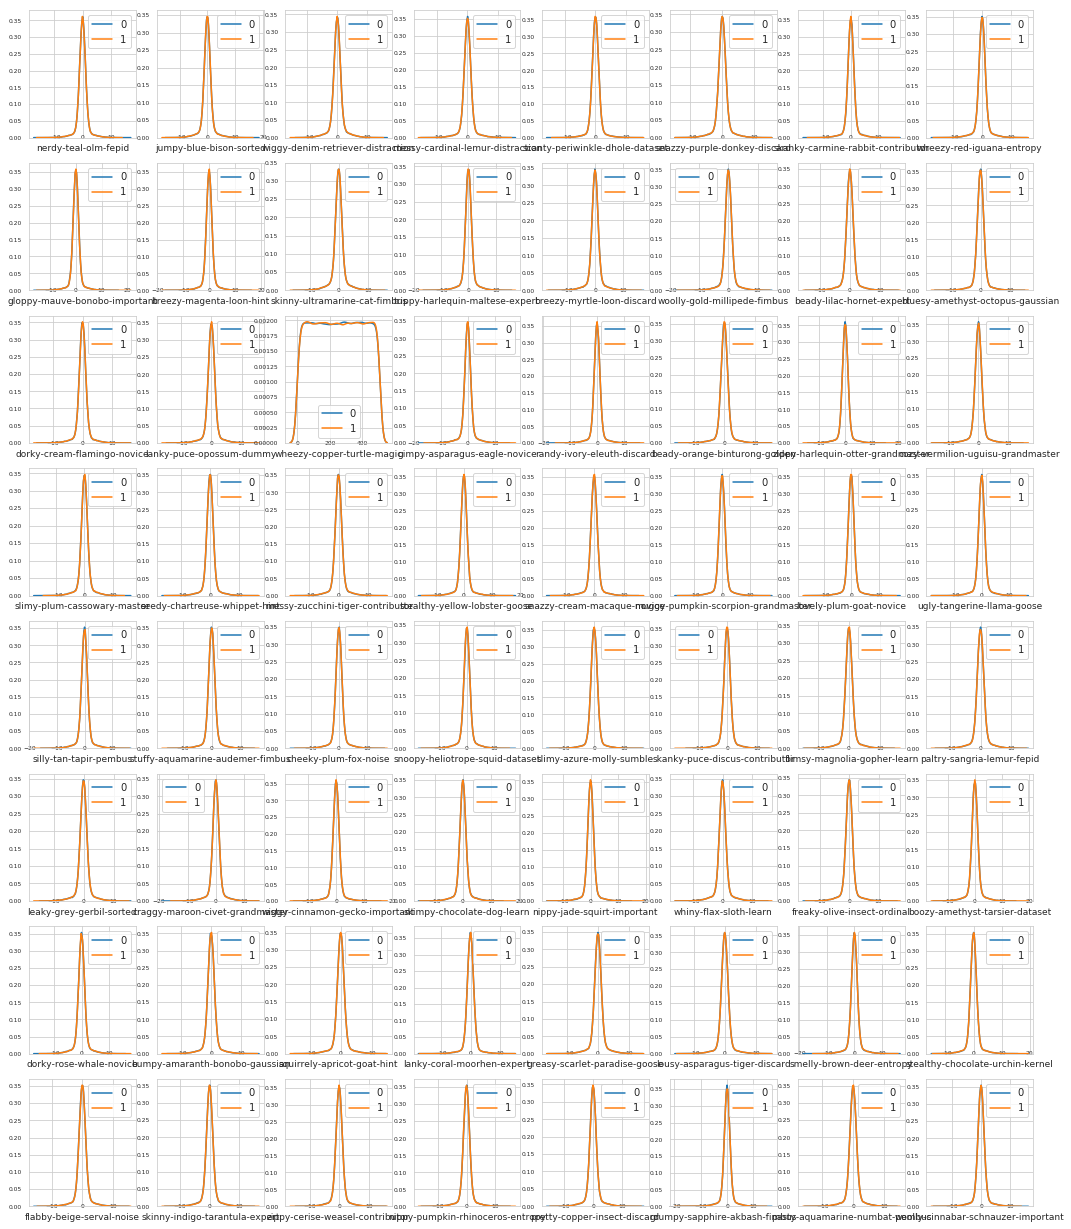

In [17]:
# Another 64 features
%time
features = train_df.columns.values[129:193]
plot_feature_distribution(t0, t1, '0', '1', features)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.7 µs


<Figure size 432x288 with 0 Axes>

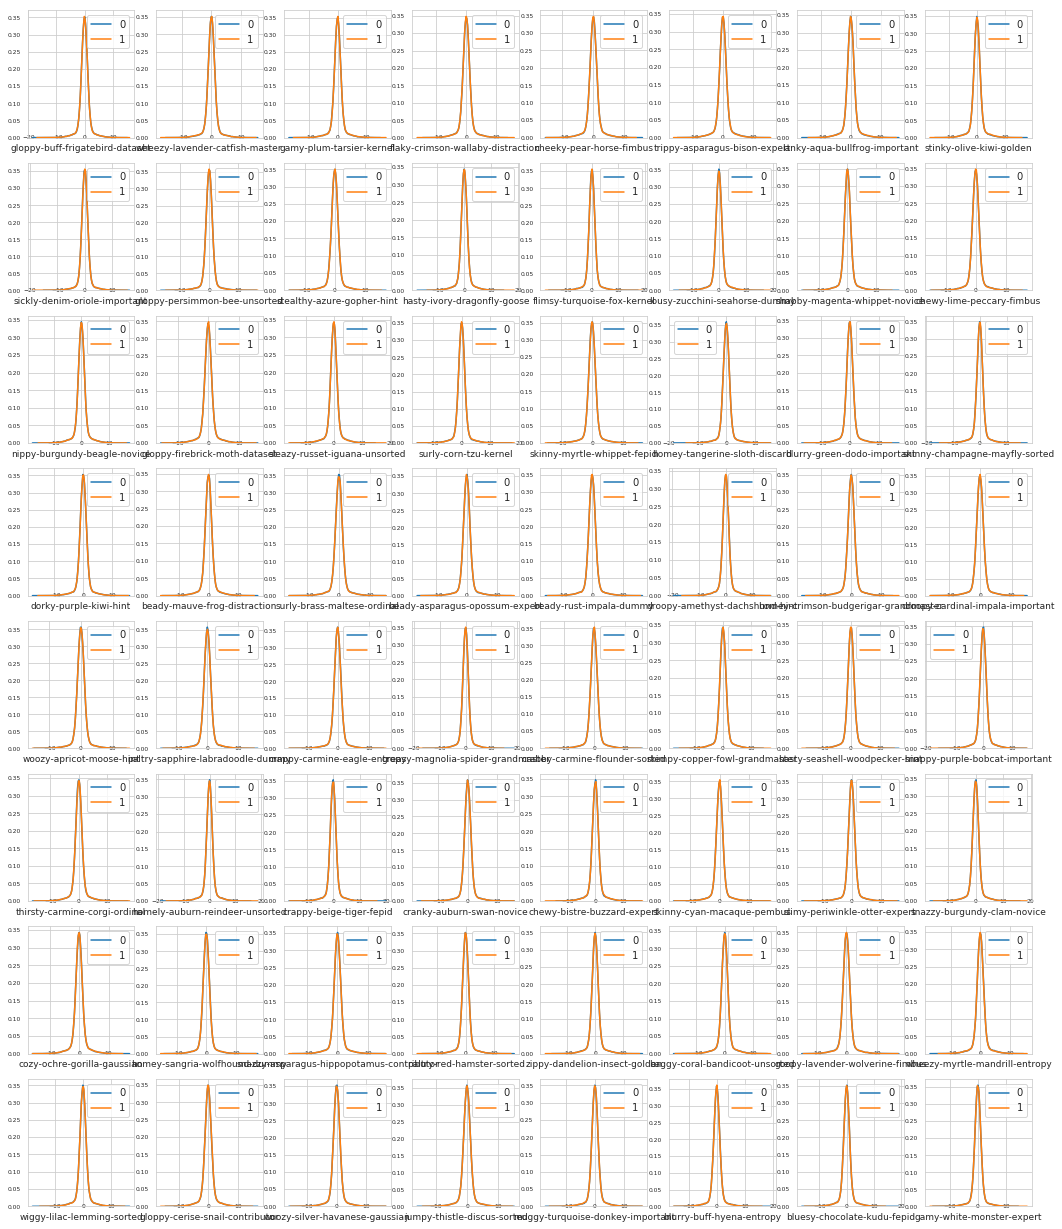

In [18]:
# Last 64 features
%time
features = train_df.columns.values[193:257]
plot_feature_distribution(t0, t1, '0', '1', features)

For all features, distribution of target==0 and target==1 seems almost identical (completely overlaid) :oooo

But there is one feature that looks very different from all other features! That is the "wheezy-copper-turtle-magic"! Let's look at that feature a little bit more!

In [19]:
train_df['wheezy-copper-turtle-magic'].describe()

count    262144.000000
mean        255.602486
std         147.920785
min           0.000000
25%         127.000000
50%         256.000000
75%         384.000000
max         511.000000
Name: wheezy-copper-turtle-magic, dtype: float64

In [20]:
test_df['wheezy-copper-turtle-magic'].describe()

count    131073.000000
mean        255.494610
std         147.726458
min           0.000000
25%         128.000000
50%         255.000000
75%         384.000000
max         511.000000
Name: wheezy-copper-turtle-magic, dtype: float64

While other features are usually within the range of -2 to 2 and are floats, this "wheezy-copper-turtle-magic" feature seems to be comprised of discrete integers and has very large values (e.g. max value is 511)

Text(0.5, 1.0, 'test')

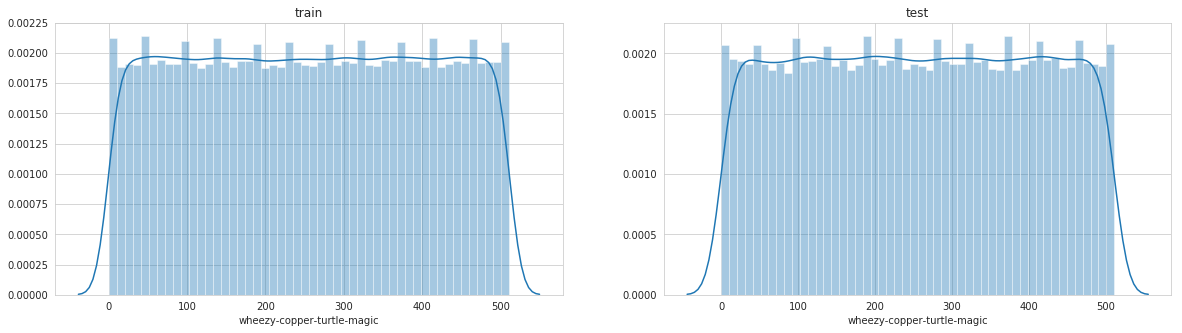

In [21]:
plt.figure(figsize=[20,5])

plt.subplot(1,2,1)
sns.distplot(train_df["wheezy-copper-turtle-magic"])
plt.title("train")

plt.subplot(1,2,2)
sns.distplot(test_df["wheezy-copper-turtle-magic"])
plt.title("test")

Text(0.5, 1.0, 'test')

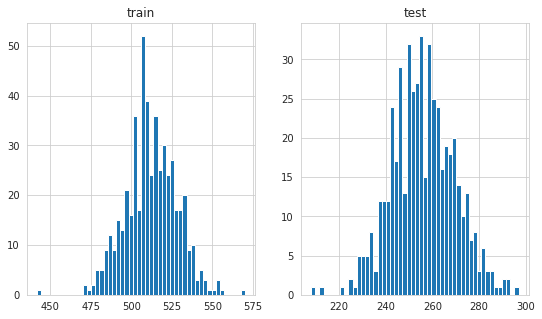

In [22]:
plt.figure(figsize=[9,5])
plt.subplot(1,2,1)
train_df.groupby("wheezy-copper-turtle-magic").size().sort_values()[::-1].hist(bins=50)
plt.title("train")

plt.subplot(1,2,2)
test_df.groupby("wheezy-copper-turtle-magic").size().sort_values()[::-1].hist(bins=50)
plt.title("test")

# How is the distribution of each feature different between train and test?

<Figure size 432x288 with 0 Axes>

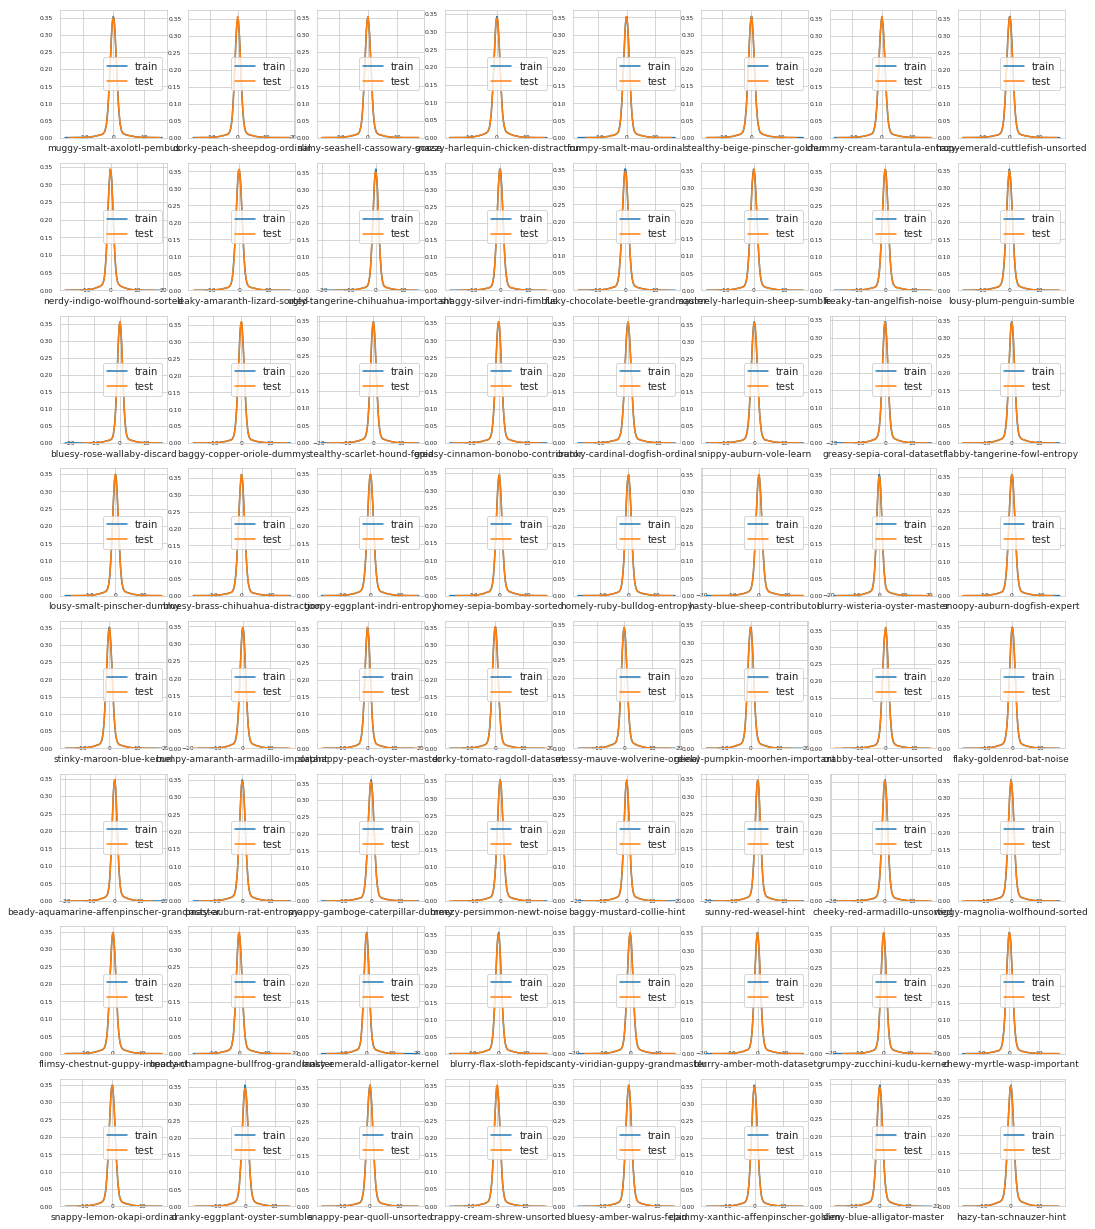

<Figure size 432x288 with 0 Axes>

In [23]:
# The first 64 features
features = train_df.columns.values[1:65]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

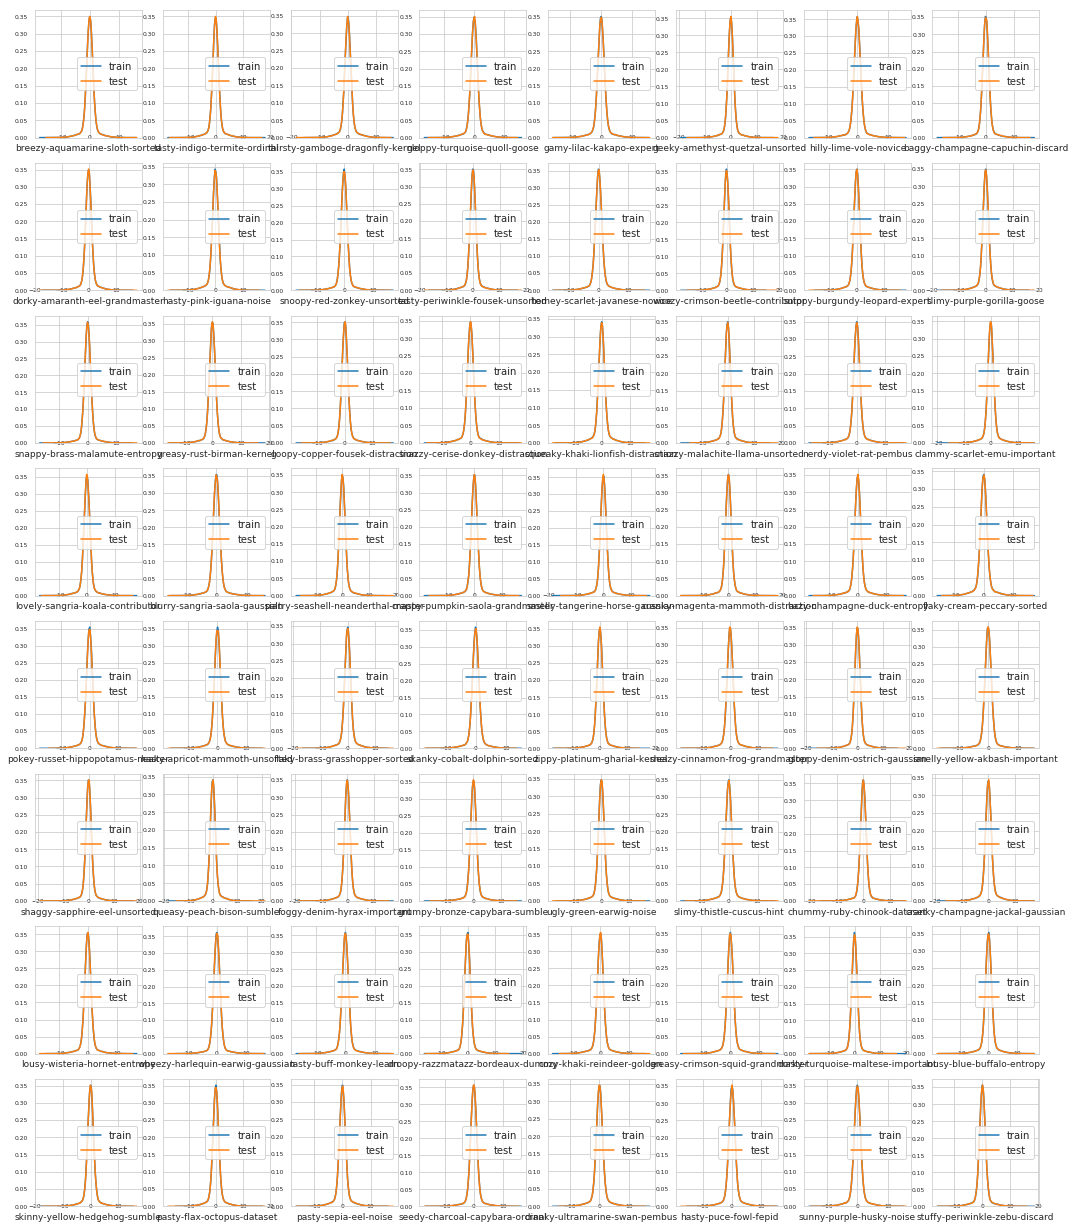

<Figure size 432x288 with 0 Axes>

In [24]:
# Another 64 features
features = train_df.columns.values[65:129]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

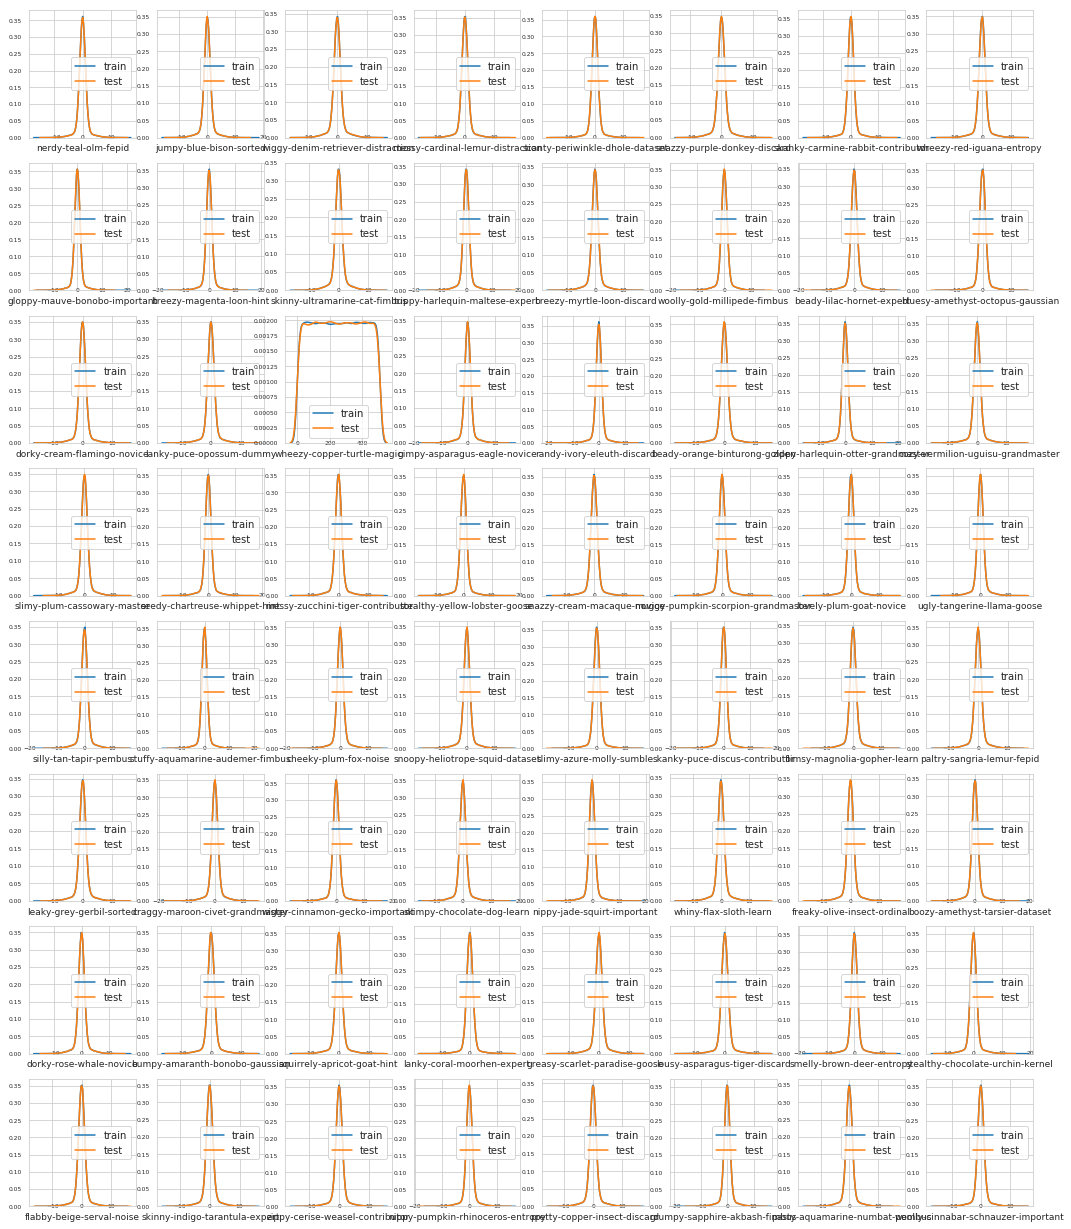

<Figure size 432x288 with 0 Axes>

In [25]:
# Another 64 features
features = train_df.columns.values[129:193]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)
plt.tight_layout()

We see that distributions of 'wheezy-copper-turtle-magic' in both train and test data here look different from others

<Figure size 432x288 with 0 Axes>

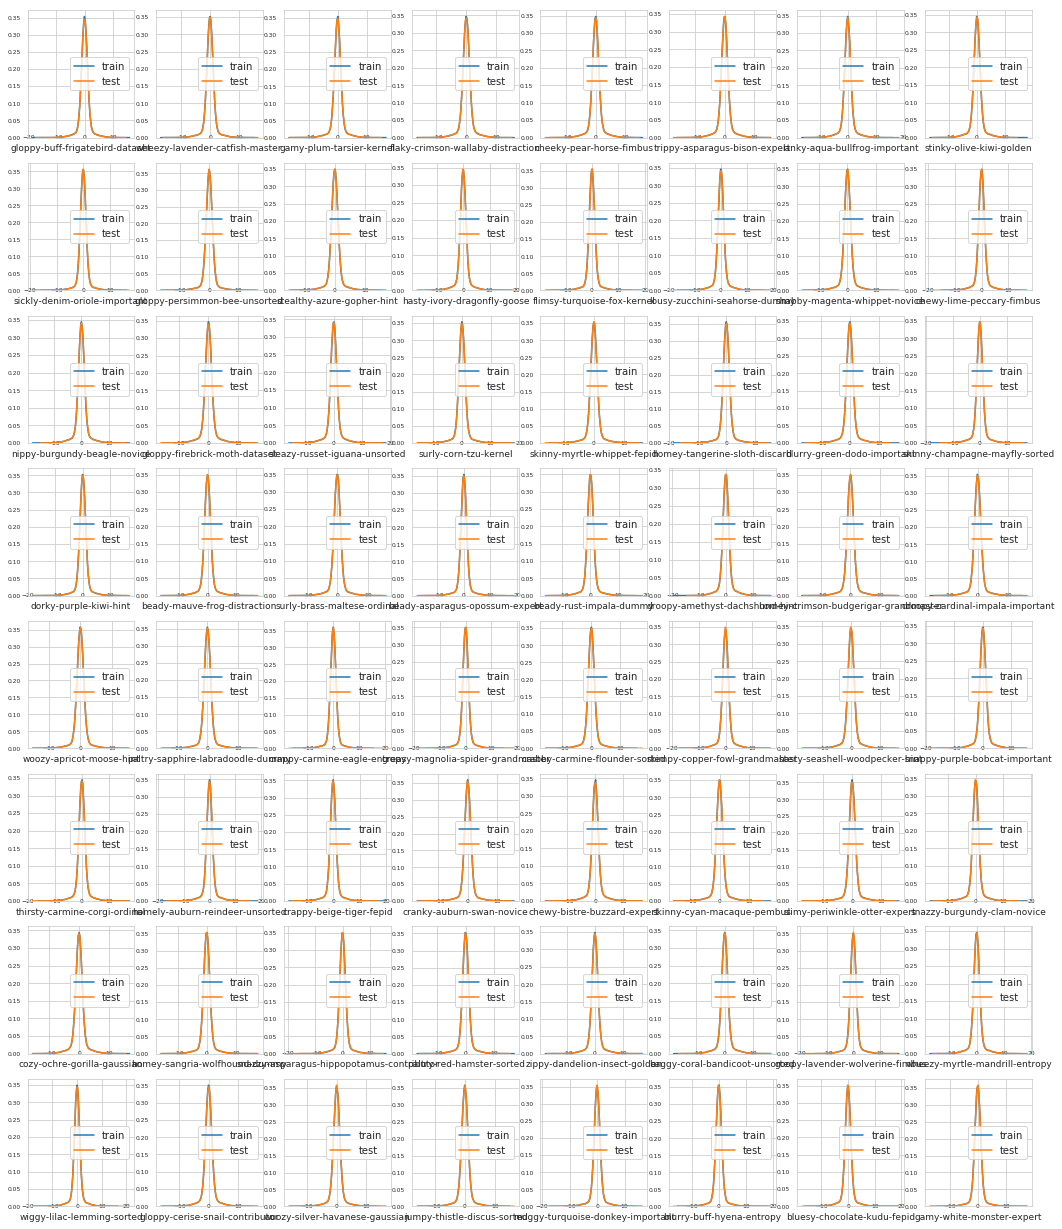

<Figure size 432x288 with 0 Axes>

In [26]:
# Last 64 features
features = train_df.columns.values[193:257]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)
plt.tight_layout()

# Correlation between features

In [27]:
# Correlations between features in training data
# Top10 lowest correlation pairs

correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
0,snazzy-burgundy-clam-novice,beady-rust-impala-dummy,0.000002
1,beady-rust-impala-dummy,snazzy-burgundy-clam-novice,0.000002
2,stinky-olive-kiwi-golden,gloppy-cerise-snail-contributor,0.000002
3,gloppy-cerise-snail-contributor,stinky-olive-kiwi-golden,0.000002
4,droopy-cardinal-impala-important,woozy-silver-havanese-gaussian,0.000003
5,woozy-silver-havanese-gaussian,droopy-cardinal-impala-important,0.000003
6,gloppy-cerise-snail-contributor,goopy-lavender-wolverine-fimbus,0.000007
7,goopy-lavender-wolverine-fimbus,gloppy-cerise-snail-contributor,0.000007
8,snazzy-burgundy-clam-novice,paltry-sapphire-labradoodle-dummy,0.000010
9,paltry-sapphire-labradoodle-dummy,snazzy-burgundy-clam-novice,0.000010


In [28]:
# Correlations between features in training data
# Top10 highest correlation pairs
correlations.tail(10)

,level_0,level_1,0
4022,stinky-olive-kiwi-golden,droopy-amethyst-dachshund-hint,0.009238
4023,droopy-amethyst-dachshund-hint,stinky-olive-kiwi-golden,0.009238
4024,trippy-asparagus-bison-expert,jumpy-thistle-discus-sorted,0.009440
4025,jumpy-thistle-discus-sorted,trippy-asparagus-bison-expert,0.009440
4026,hasty-ivory-dragonfly-goose,trippy-asparagus-bison-expert,0.009536
4027,trippy-asparagus-bison-expert,hasty-ivory-dragonfly-goose,0.009536
4028,surly-brass-maltese-ordinal,zippy-dandelion-insect-golden,0.010260
4029,zippy-dandelion-insect-golden,surly-brass-maltese-ordinal,0.010260
4030,lousy-zucchini-seahorse-dummy,surly-corn-tzu-kernel,0.011044
4031,surly-corn-tzu-kernel,lousy-zucchini-seahorse-dummy,0.011044


Correlation amongst features seems very low! probably because it's an artifical data designed to have less correlation amongst features?!

# Correlation between features and target

In [29]:
cols = [c for c in train_df.columns if c not in ['id']]
corr = train_df[cols].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corr = corr[corr['level_0'] != corr['level_1']]
corr = corr[corr['level_0'] == 'target']

In [30]:
# features with lowest correlation with target
corr.head(10)

,level_0,level_1,0
252,target,snappy-purple-bobcat-important,0.000015
260,target,snappy-gamboge-caterpillar-dummy,0.000016
533,target,bumpy-amaranth-bonobo-gaussian,0.000030
1516,target,zippy-harlequin-otter-grandmaster,0.000083
1576,target,snazzy-cerise-donkey-distraction,0.000086
1723,target,sickly-denim-oriole-important,0.000094
1859,target,freaky-tan-angelfish-noise,0.000100
1906,target,cranky-champagne-jackal-gaussian,0.000103
1915,target,smelly-brown-deer-entropy,0.000103
1936,target,cranky-magenta-mammoth-distraction,0.000104


In [31]:
# features with highest correlation with target
corr.tail(10)

,level_0,level_1,0
65468,target,wiggy-lilac-lemming-sorted,0.008520
65499,target,breezy-aquamarine-sloth-sorted,0.008641
65566,target,pokey-russet-hippopotamus-master,0.009088
65657,target,woolly-gold-millipede-fimbus,0.009552
65670,target,skanky-carmine-rabbit-contributor,0.009650
65697,target,stinky-olive-kiwi-golden,0.010132
65742,target,hasty-blue-sheep-contributor,0.010585
65768,target,muggy-turquoise-donkey-important,0.011982
65783,target,dorky-turquoise-maltese-important,0.013940
65785,target,wheezy-myrtle-mandrill-entropy,0.014259
